In [1]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 36.4 MB/s 
     |████████████████████████████████| 181 kB 50.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5d691d258dbf5f3981d2ecab96b0b5ebd18ac3e688e5ae885b744075b27b11df
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
TRAIN_PATH = "hi.translit.sampled.train.tsv"
VAL_PATH = "hi.translit.sampled.dev.tsv"
TEST_PATH = "hi.translit.sampled.test.tsv"

df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, error_bad_lines=False).dropna()
hindi_words = [list(f'\t{word}\n') for word in df[0].tolist()]
english_words = [list(f'\t{word}\n') for word in df[1].tolist()]
# Creating sorted vocabulary of source and target language
english_characters = sorted(list(set([char for word in english_words for char in word])))
hindi_characters = sorted(list(set([char for word in hindi_words for char in word])))
# Creating essential parameters
max_encoder_seq_length = (np.max([len(i) for i in english_words]))
max_decoder_seq_length = (np.max([len(i) for i in hindi_words]))
num_encoder_tokens = len(english_characters)
num_decoder_tokens = len(hindi_characters)
# Mapping each character of vocabulary to index and vice versa
input_token_index = dict([(char, i) for i, char in enumerate(english_characters)])
inverse_input_token_index = {v: k for k, v in input_token_index.items()}
target_token_index = dict([(char, i) for i, char in enumerate(hindi_characters)])
inverse_target_token_index = {v: k for k, v in target_token_index.items()}

def load_encoder_decoder_data(filepath, sep='\t', header=None):
  df = pd.read_csv(filepath, sep=sep, header=header, error_bad_lines=False).dropna()
  decoder_target_data = np.zeros((df.shape[0],max_decoder_seq_length,num_decoder_tokens), dtype="float32")
  for i, hindi_text in enumerate(df[0].tolist()):
      hindi_text = f'\t{hindi_text}\n'
      for t, char in enumerate(hindi_text):
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_target_data[i, t:, target_token_index["\n"]] = 1.0
  encoder_input_data = []
  for word in df[1].tolist():
    encoder_input_data.append([input_token_index[char] for char in f'\t{word}\n'])
  encoder_input_data = sequence.pad_sequences(encoder_input_data, maxlen=max_encoder_seq_length, padding="post")
  decoder_input_data = []
  for word in df[0].tolist():
    decoder_input_data.append([target_token_index[char] for char in f'\t{word}\n'])
  decoder_input_data = sequence.pad_sequences(decoder_input_data, maxlen=max_decoder_seq_length, padding="post")
  return encoder_input_data, decoder_input_data, decoder_target_data

# Train split
train_encoder_input_data, train_decoder_input_data, train_decoder_target = load_encoder_decoder_data(TRAIN_PATH)
# Validation split
val_encoder_input_data, val_decoder_input_data, val_decoder_target = load_encoder_decoder_data(VAL_PATH)
# Test split
test_encoder_input_data, test_decoder_input_data, test_decoder_target = load_encoder_decoder_data(TEST_PATH)

buffer_size = 100000

In [4]:
class BahdanauAttention(Layer):
  def __init__(self, units):
    super().__init__()
    self.W_decoder = Dense(units)
    self.W_encoder = Dense(units)
    self.W_aggregate = Dense(1)

  def call(self, query, values):
    query_across_time = tf.expand_dims(query, 1)
    decoder_transform = self.W_decoder(query_across_time)
    encoder_transform = self.W_encoder(values)
    score = tf.nn.tanh(encoder_transform + decoder_transform)
    score = self.W_aggregate(score)
    attention_weights = tf.nn.softmax(score, axis=1)
    context = tf.reduce_sum((attention_weights * values), axis=1)
    return context, attention_weights


class Encoder(Model):
  def __init__(self, config):
    super(Encoder, self).__init__()
    self.config = config
    
    # Embedding layer: (num_encoder_tokens, input_embedding_size)
    self.encoder_embedding = Embedding(num_encoder_tokens, self.config.input_embedding_size, name='Encoder_embeddings')
    
    # Adding encoder layer
    self.get_cell = {
        'rnn': SimpleRNN(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'gru': GRU(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'lstm': LSTM(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
    }
    self.encoder_cell = self.get_cell[self.config.cell_type]


  def call(self, encoder_input, hidden):
    encoder_embedded = self.encoder_embedding(encoder_input)
    if self.config.cell_type in ['rnn', 'gru']:
        output, state = self.get_cell[self.config.cell_type](encoder_embedded, initial_state=hidden)
    elif self.config.cell_type == "lstm":
        output, state, context= self.get_cell[self.config.cell_type](encoder_embedded, initial_state=hidden)
    return output, state

  def init_hidden_states(self):
      if self.config.cell_type in ['rnn', 'gru']:
          return tf.zeros((self.config.batch_size, self.config.hidden_units))
      else:
        return (tf.zeros((self.config.batch_size, self.config.hidden_units)),
                  tf.zeros((self.config.batch_size, self.config.hidden_units)))
        
class Decoder(Model):
  def __init__(self, config):
    super(Decoder, self).__init__()
    self.config = config
    # Attention Layer
    self.attention = BahdanauAttention(self.config.hidden_units)
    
    # Embedding layer: (num_decoder_tokens, input_embedding_size)
    self.decoder_embedding = Embedding(num_decoder_tokens, self.config.input_embedding_size)
    
    # Output dense layer: (num_decoder_tokens)
    self.decoder_dense = Dense(num_decoder_tokens)
    
    # Adding decoder layer
    self.get_cell = {
        'rnn': SimpleRNN(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'gru': GRU(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'lstm': LSTM(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
    }
    self.decoder_cell = self.get_cell[self.config.cell_type]

  def call(self, decoder_inputs, hidden, encoder_output):
    context, attention_weights = self.attention(hidden, encoder_output)
    decoder_embedded = self.decoder_embedding(decoder_inputs)
    concatenated = tf.concat([tf.expand_dims(context, 1), decoder_embedded], axis=-1)
    if self.config.cell_type in ['rnn', 'gru']:
        output, state = self.get_cell[self.config.cell_type](concatenated)
    elif self.config.cell_type == "lstm":
        output, state, context= self.get_cell[self.config.cell_type](concatenated)
    output = self.decoder_dense(tf.reshape(output, (-1, output.shape[2])))
    return output, state, attention_weights

In [ ]:
class TransliterationAttentionModel:
    def __init__(self, config):
        self.config = config
        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
        self.optimizer = Adam(learning_rate=self.config.learning_rate)
        self.loss_func = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    @tf.function()    
    def train_one_batch(self, encoder_inputs, decoder_targets):
        loss = 0
        # Initialize hidden states to zeroes
        encoder_hidden = self.encoder.init_hidden_states()
        with tf.GradientTape() as tape:
            encoder_output, decoder_hidden = self.encoder(encoder_inputs, encoder_hidden)
            decoder_input = tf.expand_dims([target_token_index['\t']] * self.config.batch_size, 1)
            for t in range(1, decoder_targets.shape[1]):
                decoder_output, decoder_hidden, attention_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
                batch_loss = self.loss_func(decoder_targets[:, t], decoder_output)
                # Ignore pad index
                batch_loss *= tf.cast(tf.math.logical_not(tf.math.equal(decoder_targets[:, t], 0)), dtype=batch_loss.dtype)
                batch_loss = tf.reduce_mean(batch_loss)
                dec_input = tf.expand_dims(decoder_targets[:, t], 1)
                loss += batch_loss
        gradients = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.attention.trainable_variables + self.decoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables + self.decoder.attention.trainable_variables + self.decoder.trainable_variables))
        return (loss / decoder_targets.shape[1])

    def train(self, dataset, batch_size, num_batches):
        for epoch in range(1, self.config.epochs+1):
            loss = 0
            # Iterate batches over dataset and train 
            for (batch, (encoder_inputs, decoder_targets)) in tqdm(enumerate(dataset.take(num_batches))):
                batch_loss = self.train_one_batch(encoder_inputs, decoder_targets)
                loss += batch_loss 
            print(f'Epoch {epoch} Loss {loss/num_batches:.4f}')
    
    def calculate_accuracy(self, split='test'):
        correct, total = 0, 0
        targets, predicted, english_words = [], [], []
        for i in range(len(test_decoder_input_data)):
            gt = ""  # fetch ground truth
            for token in test_decoder_input_data[i][1:]:
                if inverse_target_token_index[token]!="\n":
                    gt += inverse_target_token_index[token]
                else:
                    break
            english = ""  # fetch english word
            for token in test_encoder_input_data[i][1:]:
                if inverse_input_token_index[token]!="\n":
                    english += inverse_input_token_index[token]
                else:
                    break
            pred = self.get_predicted_word(test_encoder_input_data[i])
            if i % 100 == 0:
              print("english: ", english, "gt: ",gt," pred: ",pred)
            if gt == pred :
                correct += 1
            total += 1
            targets.append(gt)
            predicted.append(pred)
            english_words.append(english)
        import pandas as pd
        df=pd.DataFrame({'English': english_words, 'Predicted': predicted, 'Target': targets})
        df.to_csv('predictions_attention.csv')
        word_test_accuracy = correct / total
        print("test accuracy : " ,word_test_accuracy )
    
    def get_predicted_word(self, inputs):
        if self.config.cell_type in ['rnn', 'gru']:
            hidden = [tf.zeros((1, self.config.hidden_units))]
        else:
            hidden = [tf.zeros((1, self.config.hidden_units)),
                      tf.zeros((1, self.config.hidden_units))]          
        encoder_input = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
        encoder_output, decoder_hidden = self.encoder(encoder_input, hidden)
        decoder_input = tf.expand_dims([target_token_index['\t']], 0)  # start token
        predicted_word = ''
        all_attention_weights = np.zeros((self.max_decoder_seq_length,self.max_encoder_seq_length))
        for t in range(max_decoder_seq_length):
            decoder_output, decoder_hidden, attention_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
            token = np.argmax(decoder_output[0].numpy())
            all_attention_weights[t] = attention_weights.numpy().reshape(-1)
            if inverse_target_token_index[token] != "\n":  # end token
                predicted_word += inverse_target_token_index[token]
            else:
                return predicted_word, all_attention_weights
            decoder_input = tf.expand_dims([token], 0) 
        return predicted_word, all_attention_weights

In [10]:
# Best hyperparameter configuration
cfg_dict = {'batch_size': 256, 'cell_type': 'lstm', 'dropout': 0.3, 'epochs': 20, 'hidden_units': 256, 'initializer': 'orthogonal', 'input_embedding_size': 256, 'learning_rate': 0.002}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config = dotdict(cfg_dict)
num_batches = len(train_encoder_input_data)//config.batch_size
dataset = tf.data.Dataset.from_tensor_slices((train_encoder_input_data, train_decoder_input_data)).shuffle(buffer_size)
dataset = dataset.batch(config.batch_size, drop_remainder=True)
model = TransliterationAttentionModel(config)
model.train(dataset, config.batch_size, num_batches)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


172it [01:22,  2.08it/s]


Epoch 1 Loss 0.9952   


172it [00:43,  4.00it/s]


Epoch 2 Loss 0.5163   


172it [00:43,  4.00it/s]


Epoch 3 Loss 0.2372   


172it [00:43,  3.99it/s]


Epoch 4 Loss 0.1821   


172it [00:43,  3.99it/s]


Epoch 5 Loss 0.1592   


172it [00:43,  4.00it/s]


Epoch 6 Loss 0.1432   


172it [00:43,  4.00it/s]


Epoch 7 Loss 0.1297   


172it [00:43,  3.99it/s]


Epoch 8 Loss 0.1301   


172it [00:43,  4.00it/s]


Epoch 9 Loss 0.1124   


172it [00:43,  4.00it/s]


Epoch 10 Loss 0.1060   


172it [00:43,  3.99it/s]


Epoch 11 Loss 0.1006   


172it [00:42,  4.01it/s]


Epoch 12 Loss 0.0918   


172it [00:43,  4.00it/s]


Epoch 13 Loss 0.0879   


172it [00:42,  4.01it/s]


Epoch 14 Loss 0.0905   


172it [00:43,  4.00it/s]


Epoch 15 Loss 0.1310   


172it [00:42,  4.00it/s]


Epoch 16 Loss 0.0904   


172it [00:43,  3.99it/s]


Epoch 17 Loss 0.0798   


172it [00:43,  3.99it/s]


Epoch 18 Loss 0.0721   


172it [00:43,  3.99it/s]


Epoch 19 Loss 0.0763   


172it [00:42,  4.01it/s]

Epoch 20 Loss 0.0656   


In [ ]:
model.calculate_accuracy(split='test')

### Visualize Attention Heatmaps

In [30]:
# Attention plots
from matplotlib.font_manager import FontProperties as fp


def make_attention_heatmaps(word):
    word = f'\t{word}\n'
    tokenized = []
    for w in word:
        tokenized.append(input_token_index[w])
    padded = sequence.pad_sequences([tokenized],maxlen=max_encoder_seq_length,padding="post")
    predicted, attention = model.get_predicted_word(padded[0],True)
    attention = attention[:len(predicted), :len(word)]
    predicted = list(predicted)
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    img = sb.heatmap(attention, cmap="YlGnBu", cbar=True)
    labels = list(word)
    labels[0] = '<S>'
    labels[-1] = '<E>'
    ax.set_xticklabels(labels)
    ax.set_yticklabels(predicted, fontdict={'fontsize':10}, rotation=0, fontproperties=fp(fname='Mukta.ttf'))
    plt.show()
    return

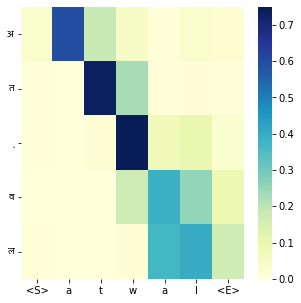

1


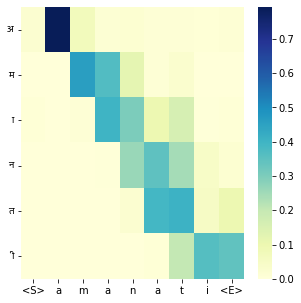

2


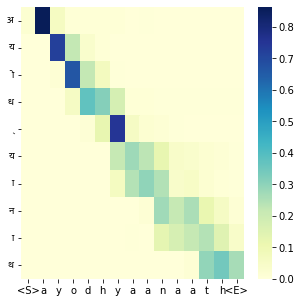

3


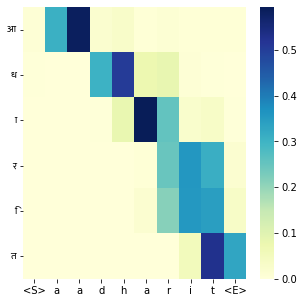

4


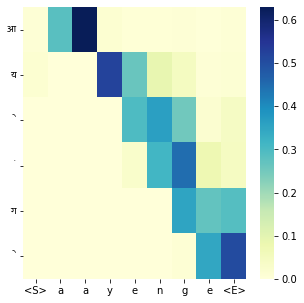

5


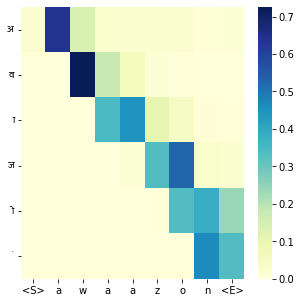

6


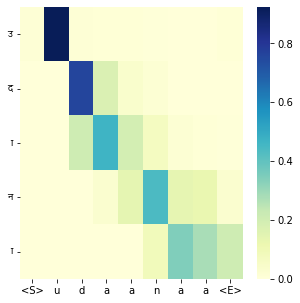

7


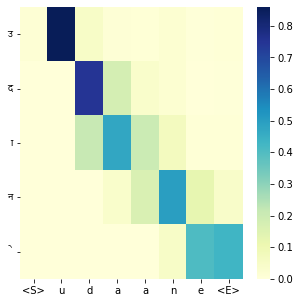

8


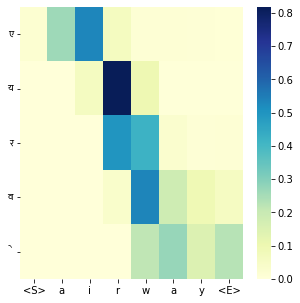

9


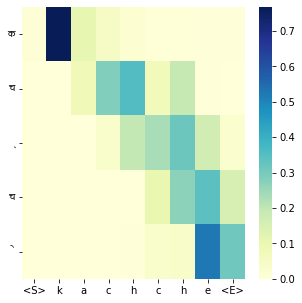

10


In [36]:
import random

idxs = [i for i in range(len(test_encoder_input_data))]
count = 1
demo_words = ['amanati', 'atwal', 'awaazon', 'udaanaa', 'aayenge', 'aadharit', 'airway', 'ayodhyaanaath', 'udaane',  'kachche']
for idx in idxs:
    word = ""
    for char in test_encoder_input_data[idx][1:]:
        if inverse_input_token_index[char]!="\n":
            word += inverse_input_token_index[char]
        else:
            break
    if word in demo_words:
      make_attention_heatmaps(word)
      print(count)
      count += 1